**Marcus Woo**

**BrainStation**

**Spring 2022**

## Notebook 2: Modeling and Model Evaluation

In this notebook, data transformation and feature engineering will beperformed, then I will build machine learning models and evaluate their performance. Our dependent variable is the `outcome` of individual patient with Covid-19, either the patient recovered or died from Covid-19. 

I will apply three machine learning models to predict Covid mortality risk.

    - Logistic Regression
    - Random Forest
    - XG boost

Then I will evaluate and compare each model, and address class imbalances.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import joblib

from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn import set_config
set_config(display='diagram')


import warnings
warnings.filterwarnings("ignore")

C:\Users\Jo\anaconda3\envs\boosting\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#import final dataset
final_df = pd.read_csv('final_dataset.csv')

final_df.head()

,Unnamed: 0,Outbreak Associated,Age Group,Source of Infection,Classification,Episode Date,Client Gender,Outcome,Ever Hospitalized,Ever in ICU,Ever Intubated,Pre-Tax Household Income,Population density per square kilometre
0,0,Sporadic,50 to 59 Years,Travel,CONFIRMED,2020/1/22,FEMALE,RESOLVED,No,No,No,64362,10087
1,1,Sporadic,50 to 59 Years,Travel,CONFIRMED,2020/1/21,MALE,RESOLVED,Yes,No,No,64362,10087
2,2,Sporadic,50 to 59 Years,Travel,CONFIRMED,2020/2/29,MALE,RESOLVED,No,No,No,64362,10087
3,3,Sporadic,50 to 59 Years,Travel,CONFIRMED,2020/3/3,MALE,RESOLVED,No,No,No,64362,10087
4,4,Sporadic,80 to 89 Years,Travel,CONFIRMED,2020/3/3,MALE,RESOLVED,No,No,No,64362,10087


In [3]:
#columns info
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270962 entries, 0 to 270961
Data columns (total 13 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   Unnamed: 0                               270962 non-null  int64 
 1   Outbreak Associated                      270962 non-null  object
 2   Age Group                                270962 non-null  object
 3   Source of Infection                      270962 non-null  object
 4   Classification                           270962 non-null  object
 5   Episode Date                             270962 non-null  object
 6   Client Gender                            270962 non-null  object
 7   Outcome                                  270962 non-null  object
 8   Ever Hospitalized                        270962 non-null  object
 9   Ever in ICU                              270962 non-null  object
 10  Ever Intubated                           270

In [4]:
#columns names
final_df.columns

Index(['Unnamed: 0', 'Outbreak Associated', 'Age Group', 'Source of Infection',
       'Classification', 'Episode Date', 'Client Gender', 'Outcome',
       'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated',
       'Pre-Tax Household Income', 'Population density per square kilometre'],
      dtype='object')

In [5]:
final_df.drop(columns = 'Unnamed: 0', inplace=True)

final_df['Episode Date'] = pd.to_datetime(final_df['Episode Date'])

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270962 entries, 0 to 270961
Data columns (total 12 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   Outbreak Associated                      270962 non-null  object        
 1   Age Group                                270962 non-null  object        
 2   Source of Infection                      270962 non-null  object        
 3   Classification                           270962 non-null  object        
 4   Episode Date                             270962 non-null  datetime64[ns]
 5   Client Gender                            270962 non-null  object        
 6   Outcome                                  270962 non-null  object        
 7   Ever Hospitalized                        270962 non-null  object        
 8   Ever in ICU                              270962 non-null  object        
 9   Ever Intubated            

## Train-test split

In [6]:
#assign X and y
X = final_df.drop(columns =['Outcome', 'Source of Infection'], )
y = final_df['Outcome']

In [7]:
# transform dependent variable into 0 and 1 
le = LabelEncoder()

#fit and transform
y = le.fit_transform(y)

In [8]:
#sanity check
np.unique(y, return_counts = True)

(array([0, 1]), array([266941,   4021], dtype=int64))

In [9]:
#train- test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(216769, 10) (54193, 10) (216769,) (54193,)


In [10]:
#sanity check - make sure the proportion of fatal cases are the same between train and test set
np.unique(y_test, return_counts = True)

(array([0, 1]), array([53389,   804], dtype=int64))

In [11]:
X_train_with_hospitalization = X_train.copy()
X_test_with_hospitalization = X_test.copy()

## Feature engineering

The severity of Covid is dynamic, and there are more deaths on certain days and months, so I believe the element of time will be a good predictor of Covid. I will extract the month and year from the episode date, as well as create a new variable `days elapsed` by subtracting the `episode date` with the date of the first case reported in January of 2020.

In [12]:
#creating month and year and `episode date` column
X_train_with_hospitalization['Month'] = X_train_with_hospitalization['Episode Date'].dt.month
X_train_with_hospitalization['Year'] =X_train_with_hospitalization['Episode Date'].dt.year


X_test_with_hospitalization['Month'] =X_test_with_hospitalization['Episode Date'].dt.month
X_test_with_hospitalization['Year'] =X_test_with_hospitalization['Episode Date'].dt.year

In [13]:
#create time elasped variable
X_train_with_hospitalization['days elapsed'] = X_train_with_hospitalization['Episode Date']- min(X_train_with_hospitalization['Episode Date'])

#turning it into integers
X_train_with_hospitalization['days elapsed'] = X_train_with_hospitalization['days elapsed'].dt.days.astype('int16')

In [14]:
#create variable for test set
X_test_with_hospitalization['days elapsed'] = X_test_with_hospitalization['Episode Date']- min(X_train_with_hospitalization['Episode Date'])

#change column to int
X_test_with_hospitalization['days elapsed'] = X_test_with_hospitalization['days elapsed'].dt.days.astype('int16')

#sanity check
X_test_with_hospitalization.head()

,Outbreak Associated,Age Group,Classification,Episode Date,Client Gender,Ever Hospitalized,Ever in ICU,Ever Intubated,Pre-Tax Household Income,Population density per square kilometre,Month,Year,days elapsed
204760,Sporadic,19 and younger,PROBABLE,2021-04-02,Other,No,No,No,56563,3377,4,2021,437
80171,Sporadic,30 to 39 Years,CONFIRMED,2021-04-23,MALE,No,No,No,66241,1117,4,2021,458
150027,Sporadic,19 and younger,CONFIRMED,2021-04-29,FEMALE,No,No,No,46475,5864,4,2021,464
52297,Sporadic,20 to 29 Years,PROBABLE,2022-01-14,MALE,No,No,No,49838,9511,1,2022,724
59222,Sporadic,30 to 39 Years,CONFIRMED,2020-12-11,FEMALE,No,No,No,90934,4209,12,2020,325


In [15]:
#sanity check
X_train_with_hospitalization

,Outbreak Associated,Age Group,Classification,Episode Date,Client Gender,Ever Hospitalized,Ever in ICU,Ever Intubated,Pre-Tax Household Income,Population density per square kilometre,Month,Year,days elapsed
131584,Outbreak Associated,90 and older,CONFIRMED,2020-06-23,FEMALE,No,No,No,71646,2840,6,2020,154
267192,Outbreak Associated,80 to 89 Years,CONFIRMED,2020-03-27,MALE,No,No,No,64522,3148,3,2020,66
22758,Sporadic,50 to 59 Years,CONFIRMED,2021-12-27,FEMALE,No,No,No,57825,10863,12,2021,706
103912,Sporadic,40 to 49 Years,CONFIRMED,2020-08-17,MALE,No,No,No,53644,6144,8,2020,209
56367,Sporadic,40 to 49 Years,PROBABLE,2021-12-31,FEMALE,No,No,No,80260,6770,12,2021,710
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259744,Sporadic,30 to 39 Years,CONFIRMED,2021-12-15,FEMALE,No,No,No,55454,4356,12,2021,694
238660,Sporadic,50 to 59 Years,CONFIRMED,2021-10-29,MALE,No,No,No,46811,6442,10,2021,647
207253,Sporadic,30 to 39 Years,CONFIRMED,2021-04-13,MALE,No,No,No,49720,5073,4,2021,448
89707,Sporadic,50 to 59 Years,CONFIRMED,2020-12-29,MALE,No,No,No,47173,2337,12,2020,343


In [16]:
#drop `episode date` column for both train and test set
X_train_with_hospitalization.drop(columns = 'Episode Date', inplace = True)
X_test_with_hospitalization.drop(columns = 'Episode Date', inplace = True)

In [17]:
# create a list for numeric variables
numeric_column = list(X_train_with_hospitalization.select_dtypes("number").columns)

numeric_column

['Pre-Tax Household Income',
 'Population density per square kilometre',
 'Month',
 'Year',
 'days elapsed']

In [18]:
#create a list for categorical variables
categorical_column = list(X_train_with_hospitalization.select_dtypes("object").columns)

categorical_column

['Outbreak Associated',
 'Age Group',
 'Classification',
 'Client Gender',
 'Ever Hospitalized',
 'Ever in ICU',
 'Ever Intubated']

I will use ordinal encoding for `Age Group`, and the rest of the features with one hot encoder.

In [19]:
categorical_column.remove('Age Group')

categorical_column

['Outbreak Associated',
 'Classification',
 'Client Gender',
 'Ever Hospitalized',
 'Ever in ICU',
 'Ever Intubated']

## Data Transformation, Modeling and Model Evaluation

### Logistic Regression

In [20]:
#column transformer
column_transform_logreg = ColumnTransformer(
    transformers = [
        ('numeric scale', StandardScaler(), numeric_column),
        ('categorical ordinal', OrdinalEncoder(handle_unknown = 'error'), ['Age Group']),
        ('categorical onehot', OneHotEncoder(handle_unknown = 'error', drop = 'if_binary'), categorical_column)],
remainder = 'passthrough')

For numeric variables, I will use standard scaler to normalize the data. For categorical variables, I will use one hot encoding except for `Age Group` where I will use ordinal encoding.

In [21]:
#pipeline for logistic regression
logit_pipeline = Pipeline(steps =[
    ('Column Transform', column_transform_logreg),
    ('logit', LogisticRegression())
])

logit_pipeline

Pipeline(steps=[('Column Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric scale',
                                                  StandardScaler(),
                                                  ['Pre-Tax Household Income',
                                                   'Population density per '
                                                   'square kilometre',
                                                   'Month', 'Year',
                                                   'days elapsed']),
                                                 ('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('logit', LogisticRegression())])

In [22]:
#setting parameter for grid search
logit_parameter = [{'logit__solver':['saga'],
                    'logit__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'logit__penalty': ['l1', 'l2']},
                   {'logit__solver':['lbfgs'],
                    'logit__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'logit__penalty': ['l2']
                   }]

#### Warning!!  long run time - Grid search !!

In [25]:
# Logit Grid search
logit_grid_search = GridSearchCV(estimator = logit_pipeline, param_grid= logit_parameter, cv = 10)

logit_grid_search.fit(X_train_with_hospitalization, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Column Transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric '
                                                                         'scale',
                                                                         StandardScaler(),
                                                                         ['Pre-Tax '
                                                                          'Household '
                                                                          'Income',
                                                                          'Population '
                                                                          'density '
                                                                          'per '
                                                                          'square '
                                                                          'kilometre',
                                                                          'Month',
                                                                          'Year',
                                                                          'days '
                                                                          'elapsed']),
                                                                        ('categorical '
                                                                         'ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Age '
                                                                          'Group']),
                                                                        ('categorical '
                                                                         'onehot',
                                                                         OneHot...
                                                                         ['Outbreak '
                                                                          'Associated',
                                                                          'Classification',
                                                                          'Client '
                                                                          'Gender',
                                                                          'Ever '
                                                                          'Hospitalized',
                                                                          'Ever '
                                                                          'in '
                                                                          'ICU',
                                                                          'Ever '
                                                                          'Intubated'])])),
                                       ('logit', LogisticRegression())]),
             param_grid=[{'logit__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'logit__penalty': ['l1', 'l2'],
                          'logit__solver': ['saga']},
                         {'logit__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'logit__penalty': ['l2'],
                          'logit__solver': ['lbfgs']}])

In [24]:
print(f' The best params is: {logit_grid_search.best_params_}')

 The best params is: {'logit__C': 100, 'logit__penalty': 'l1', 'logit__solver': 'saga'}


The best results is to use LASSO regression (L1 penalty) with optimal c value of 100.

In [27]:
print(f' training accuracy : {logit_grid_search.score(X_train_with_hospitalization, y_train)}')
print(f' testing accuracy : {logit_grid_search.score(X_test_with_hospitalization, y_test)}')

 training accuracy : 0.9861234770654476
 testing accuracy : 0.9858468805934346


In [26]:
#save best RF model
joblib.dump(logit_grid_search, 'logistic_reg_model.pkl')

['logistic_reg_model.pkl']

In [23]:
#load model from joblib
logit_grid_search = joblib.load('logistic_reg_model.pkl')

#sanity check to see if model achieved the same result as above
print(f'Test accuracy score : {logit_grid_search.score(X_test_with_hospitalization, y_test)}')


Test accuracy score : 0.9858468805934346


In [24]:
#predict classes
y_pred_lg = logit_grid_search.predict(X_test_with_hospitalization)

#create confusion matrix
cf_matrix_lg = confusion_matrix(y_test, y_pred_lg)

# label rows and columns
cf_lg_df = pd.DataFrame(
    cf_matrix_lg, 
    columns=["Predicted Resolved", "Predicted Fatal"],
    index=["True Resolved", "True Fatal"]
)

display(cf_lg_df)

,Predicted Resolved,Predicted Fatal
True Resolved,53200,189
True Fatal,578,226


Despite having a high accuracy score, we see a high number(578) of false negatives, meaning we misclassified a lot of high-risk Covid patients as low-risk.

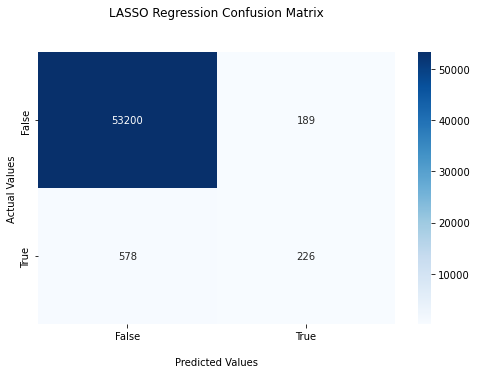

In [25]:
#plot confusion matrix
plt.figure(figsize= (8,5))
ax = sns.heatmap(cf_matrix_lg, annot=True, cmap='Blues', fmt='d')

ax.set_title('LASSO Regression Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
#classificaion report
lg_report = classification_report(y_test, y_pred_lg)

print(lg_report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     53389
           1       0.54      0.28      0.37       804

    accuracy                           0.99     54193
   macro avg       0.77      0.64      0.68     54193
weighted avg       0.98      0.99      0.98     54193



In [27]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_lg)}')
print(f'F1 Score : {f1_score(y_test,y_pred_lg)}')
print(f'ROC AUC Score : {roc_auc_score(y_test,y_pred_lg)}')

Accuracy Score : 0.9858468805934346
F1 Score : 0.37079573420836753
ROC AUC Score : 0.6387772361478304


Model         | Accuracy |  F1 |    AUC 
------------- | -------------|------------- | ---------
LASSO Regression  | 0.986 | 0.371 |  0.639


### Random Forest 

In [20]:
#column transformer
column_transform_tree = ColumnTransformer(
    transformers = [
        ('categorical ordinal', OrdinalEncoder(handle_unknown = 'error'), ['Age Group']),
        ('categorical onehot', OneHotEncoder(handle_unknown = 'error', drop = 'if_binary'), categorical_column)],
remainder = 'passthrough')

In [29]:
#pipeline for random forest
rf_pipeline = Pipeline(steps =[
    ('Column Transform', column_transform_tree),
    ('rf', RandomForestClassifier())
])

rf_pipeline

Pipeline(steps=[('Column Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('rf', RandomForestClassifier())])

In [30]:
rf_parameter = [{
    'rf__n_estimators': [50,100,150,200,250,300,350],
    'rf__max_depth':[4,5,6,7,8,9,10,11,12]
}]

### WARNING long run time!

In [50]:
#random forest grid search
rf_grid_search = GridSearchCV(estimator= rf_pipeline, param_grid=rf_parameter, cv = 5)

rf_grid_search.fit(X_train_with_hospitalization, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Column Transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical '
                                                                         'ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Age '
                                                                          'Group']),
                                                                        ('categorical '
                                                                         'onehot',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Outbreak '
                                                                          'Associated',
                                                                          'Classification',
                                                                          'Client '
                                                                          'Gender',
                                                                          'Ever '
                                                                          'Hospitalized',
                                                                          'Ever '
                                                                          'in '
                                                                          'ICU',
                                                                          'Ever '
                                                                          'Intubated'])])),
                                       ('rf', RandomForestClassifier())]),
             param_grid=[{'rf__max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
                          'rf__n_estimators': [50, 100, 150, 200, 250, 300,
                                               350]}])

In [60]:
#save best RF model
joblib.dump(rf_grid_search, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [44]:
#show best parameter
print(rf_grid_search.best_estimator_)

Pipeline(steps=[('Column Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('rf', RandomForestClassifier(max_depth=11, n_estimators=200))])


In [31]:
#load model from joblib
rf_grid_search = joblib.load('random_forest_model.pkl')

print(f' training accuracy : {rf_grid_search.score(X_train_with_hospitalization, y_train)}')
print(f' testing accuracy : {rf_grid_search.score(X_test_with_hospitalization, y_test)}')

 training accuracy : 0.9893158154533167
 testing accuracy : 0.9862897422176296


In [32]:
#get class prediction
y_pred_rf = rf_grid_search.predict(X_test_with_hospitalization)

#generate confusion matrix
cf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# label rows and columns
cf_rf_df = pd.DataFrame(
    cf_matrix_rf, 
    columns=["Predicted Resolved", "Predicted Fatal"],
    index=["True Resolved", "True Fatal"]
)

display(cf_rf_df)

,Predicted Resolved,Predicted Fatal
True Resolved,53276,113
True Fatal,630,174


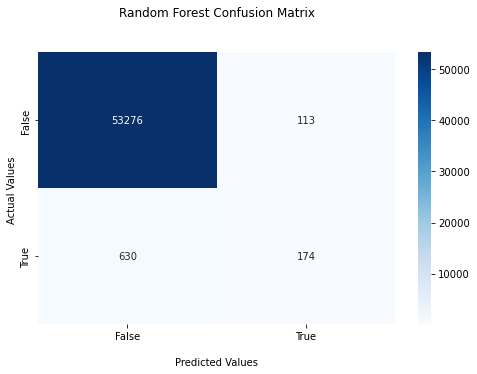

In [33]:
#plot confusion matrix
plt.figure(figsize= (8,5))
ax = sns.heatmap(cf_matrix_rf, annot=True, cmap='Blues', fmt='d')

ax.set_title('Random Forest Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [34]:
#classification report
rf_report = classification_report(y_test, y_pred_rf)

print(rf_report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     53389
           1       0.61      0.22      0.32       804

    accuracy                           0.99     54193
   macro avg       0.80      0.61      0.66     54193
weighted avg       0.98      0.99      0.98     54193



In [35]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_rf)}')
print(f'F1 Score : {f1_score(y_test,y_pred_rf)}')
print(f'ROC AUC Score : {roc_auc_score(y_test,y_pred_rf)}')

Accuracy Score : 0.9862897422176296
F1 Score : 0.31897341888175984
ROC AUC Score : 0.6071506847936422


Model         | Accuracy |  F1 |    AUC 
------------- | -------------|------------- | ---------
LASSO Regression  | 0.986 | 0.371 |  0.639
Random Forest | 0.986 | 0.319 | 0.607

### XGboost

In [36]:
#pipeline for XGboost
xgb_pipeline = Pipeline(steps =[
    ('Column Transform', column_transform_tree),
    ('xgb', xgb.XGBClassifier())
])

xgb_pipeline

Pipeline(steps=[('Column Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=No...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None))])

In [37]:
#XGBoost parameter
xgb_param = [{
    'xgb__max_depth':[2,3,4,5],
    'xgb__n_estimators':[20,40,60,80],
    'xgb__eval_metric': ['mlogloss']
}]

In [ ]:
#XGB grid search
xgb_grid_search = GridSearchCV(estimator= xgb_pipeline, param_grid=xgb_param, cv = 5, verbose=1)

xgb_grid_search.fit(X_train_with_hospitalization, y_train)

In [ ]:
#save best RF model
joblib.dump(xgb_grid_search, 'xgb_model.pkl')

In [40]:
print(xgb_grid_search.best_params_)

{'xgb__eval_metric': 'mlogloss', 'xgb__max_depth': 3, 'xgb__n_estimators': 40}


In [39]:
#load model from joblib
xgb_grid_search = joblib.load('xgb_model.pkl')

print(f' training accuracy : {xgb_grid_search.score(X_train_with_hospitalization, y_train)}')
print(f' testing accuracy : {xgb_grid_search.score(X_test_with_hospitalization, y_test)}')

 training accuracy : 0.9869123352508892
 testing accuracy : 0.986160574243906


In [41]:
#predict y class
y_pred_xgb = xgb_grid_search.predict(X_test_with_hospitalization)

#generate confusion matrix
cf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# label rows and columns
cf_xgb_df = pd.DataFrame(
    cf_matrix_xgb, 
    columns=["Predicted Resolved", "Predicted Fatal"],
    index=["True Resolved", "True Fatal"]
)

display(cf_xgb_df)

,Predicted Resolved,Predicted Fatal
True Resolved,53236,153
True Fatal,597,207


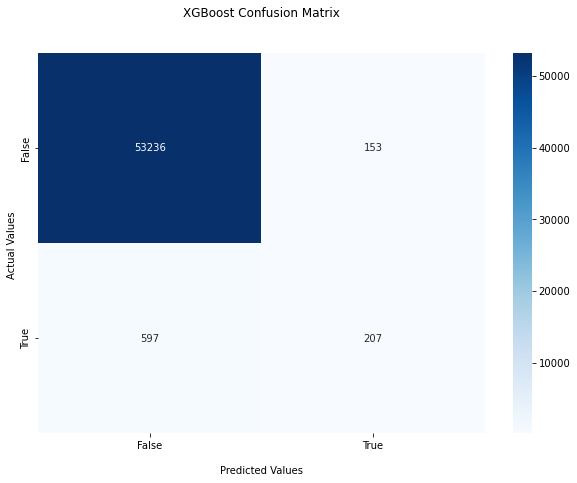

In [42]:
#plot confusion matrix
plt.figure(figsize= (10,7))
ax = sns.heatmap(cf_matrix_xgb, annot=True, cmap='Blues', fmt='d')

ax.set_title('XGBoost Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [43]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_xgb)}')
print(f'F1 Score : {f1_score(y_test,y_pred_xgb)}')
print(f'ROC AUC Score : {roc_auc_score(y_test,y_pred_xgb)}')

Accuracy Score : 0.986160574243906
F1 Score : 0.3556701030927835
ROC AUC Score : 0.6272984638514895


Model         | Accuracy |  F1 |    AUC 
------------- | -------------|------------- | ---------
LASSO Regression  | 0.986 | 0.371 |  0.639
Random Forest | 0.986 | 0.319 | 0.607
XGBoost | 0.986 | 0.356 | 0.627

`LASSO regression`, `Random Forest`, and `XGBoost` are applied and grid search is performed for hyperparameter optimization. All three models performed similarly in terms of accuracy score, LASSO Regression achieved a slightly higher F1 score and AUC score than XGBoost and Random Forest. All the models achieved a high accuracy score of 98% mainly because we have imbalanced classes, so the accuracy score is not a good metric for model performance. Next, we will address this problem of imbalanced classes by changing the class weights and rerunning the model with optimized hyperparameters to compare the AUC score.

## Address imbalanced classes and re-run models

### LASSO regression

From hyperparameter tuning above, we see that fitting a LASSO regression (penalty = 'L1') with `C = 100` and solver as `saga` gives the best model.

In [44]:
#column transformer
column_transform_logreg_final = ColumnTransformer(
    transformers = [
        ('numeric scale', StandardScaler(), numeric_column),
        ('categorical ordinal', OrdinalEncoder(handle_unknown = 'error'), ['Age Group']),
        ('categorical onehot', OneHotEncoder(handle_unknown = 'error', drop = 'if_binary'), categorical_column)],
remainder = 'passthrough')

In [45]:
#pipeline for logistic regression
logit_pipeline_final = Pipeline(steps =[
    ('Column _finalTransform', column_transform_logreg_final),
    ('logit', LogisticRegression(C = 100, penalty = 'l1', solver = 'saga', class_weight='balanced', random_state = 42  ))
])

#fit
logit_pipeline_final.fit(X_train_with_hospitalization, y_train)

Pipeline(steps=[('Column _finalTransform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric scale',
                                                  StandardScaler(),
                                                  ['Pre-Tax Household Income',
                                                   'Population density per '
                                                   'square kilometre',
                                                   'Month', 'Year',
                                                   'days elapsed']),
                                                 ('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('logit',
                 LogisticRegression(C=100, class_weight='balanced',
                                    penalty='l1', random_state=42,
                                    solver='saga'))])

In [46]:
#predict classes
y_pred_lg_final = logit_pipeline_final.predict(X_test_with_hospitalization)

cf_matrix_lg_final = confusion_matrix(y_test, y_pred_lg_final)

# label rows and columns
cf_lasso_df = pd.DataFrame(
    cf_matrix_lg_final, 
    columns=["Predicted Resolved", "Predicted Fatal"],
    index=["True Resolved", "True Fatal"]
)

display(cf_lasso_df)

,Predicted Resolved,Predicted Fatal
True Resolved,49617,3772
True Fatal,43,761


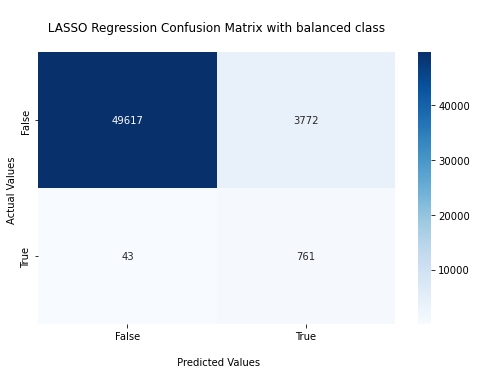

In [47]:
#plot confusion matrix
plt.figure(figsize= (8,5))
ax = sns.heatmap(cf_matrix_lg_final, annot=True, cmap='Blues', fmt='d')

ax.set_title('\n LASSO Regression Confusion Matrix with balanced class \n');
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [48]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_lg_final)}')
print(f'F1 Score : {f1_score(y_test,y_pred_lg_final)}')
print(f'ROC AUC Score : {roc_auc_score(y_test,y_pred_lg_final)}')

Accuracy Score : 0.9296034543206687
F1 Score : 0.2851789394791081
ROC AUC Score : 0.9379330775927999


Model         | Accuracy |  F1 |    AUC 
------------- | -------------|------------- | ---------
LASSO Regression  | 0.930 | 0.285 |  0.938


### Random Forest


re-run model with max_depth = 11, n_estimators = 200

In [49]:
#create pipeline for second run
rf_pipeline_final = Pipeline(steps =[
    ('Column Transform', column_transform_tree),
    ('rf', RandomForestClassifier(max_depth=11, n_estimators= 200, class_weight = 'balanced', random_state= 42))
])


#fit model
rf_pipeline_final.fit(X_train_with_hospitalization, y_train)

Pipeline(steps=[('Column Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=11,
                                        n_estimators=200, random_state=42))])

In [50]:
#predict y classes
y_pred_rf_final = rf_pipeline_final.predict(X_test_with_hospitalization)

#create confusion matrix
cf_matrix_cf_final = confusion_matrix(y_test, y_pred_rf_final)

# label rows and columns
cf_rf2_df = pd.DataFrame(
    cf_matrix_cf_final, 
    columns=["Predicted Resolved", "Predicted Fatal"],
    index=["True Resolved", "True Fatal"]
)

display(cf_rf2_df)

,Predicted Resolved,Predicted Fatal
True Resolved,51142,2247
True Fatal,94,710


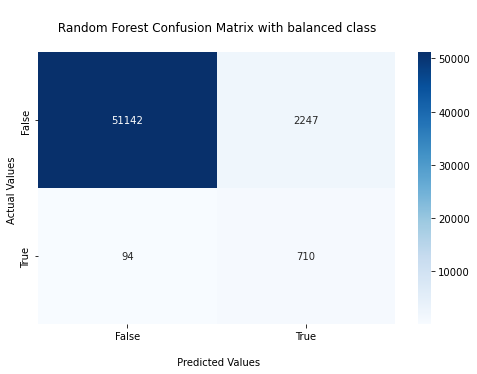

In [51]:
#plot confusion matrix
plt.figure(figsize= (8,5))
ax = sns.heatmap(cf_matrix_cf_final, annot=True, cmap='Blues', fmt='d')

ax.set_title('\n Random Forest Confusion Matrix with balanced class \n');
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [52]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_rf_final)}')
print(f'F1 Score : {f1_score(y_test,y_pred_rf_final)}')
print(f'ROC AUC Score : {roc_auc_score(y_test,y_pred_rf_final)}')

Accuracy Score : 0.956802539073312
F1 Score : 0.3775591597979261
ROC AUC Score : 0.9204986278780479


Model         | Accuracy |  F1 |    AUC 
------------- | -------------|------------- | ---------
LASSO Regression  | 0.930 | 0.285 |  0.938
Random Forest | 0.957 | 0.378 | 0.920

### XGBoost 

In [29]:
#address imbalanced classes
weight = sum(y_train == 0) / sum(y_train == 1)

weight

66.38234379857009

In [30]:
#pipeline for XGboost
xgb_pipeline_final = Pipeline(steps =[
    ('Column Transform', column_transform_tree),
    ('xgb', xgb.XGBClassifier(max_depth = 3, n_estimators = 40, eval_metric = 'mlogloss', scale_pos_weight = weight, random_state=42))
])

xgb_pipeline_final.fit(X_train_with_hospitalization, y_train)

Pipeline(steps=[('Column Transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical ordinal',
                                                  OrdinalEncoder(),
                                                  ['Age Group']),
                                                 ('categorical onehot',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Outbreak Associated',
                                                   'Classification',
                                                   'Client Gender',
                                                   'Ever Hospitalized',
                                                   'Ever in ICU',
                                                   'Ever Intubated'])])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gb...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=3, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=40,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=66.38234379857009, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [31]:
#predict y classes
y_pred_xgb_final = xgb_pipeline_final.predict(X_test_with_hospitalization)

#create confusion matrix
cf_matrix_xgb_final = confusion_matrix(y_test, y_pred_xgb_final)

# label rows and columns
cf_xgb_df = pd.DataFrame(
    cf_matrix_xgb_final, 
    columns=["Predicted Resolved", "Predicted Fatal"],
    index=["True Resolved", "True Fatal"]
)

display(cf_xgb_df)

,Predicted Resolved,Predicted Fatal
True Resolved,50136,3253
True Fatal,47,757


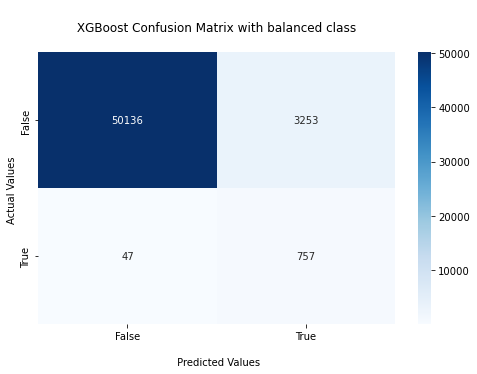

In [32]:
#plot confusion matrix
plt.figure(figsize= (8,5))
ax = sns.heatmap(cf_matrix_xgb_final, annot=True, cmap='Blues', fmt='d')

ax.set_title('\n XGBoost Confusion Matrix with balanced class \n');
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
print(f'Accuracy Score : {accuracy_score(y_test,y_pred_xgb_final)}')
print(f'F1 Score : {f1_score(y_test,y_pred_xgb_final)}')
print(f'ROC AUC Score : {roc_auc_score(y_test,y_pred_xgb_final)}')
print(f' PR curve {average_precision_score(y_test,y_pred_xgb_final)}')

Accuracy Score : 0.9391065266731866
F1 Score : 0.31449937681761525
ROC AUC Score : 0.9403060672028047
 PR curve 0.1786097924856556


Model         | Accuracy |  F1 |    AUC 
------------- | -------------|------------- | ---------
LASSO Regression  | 0.930 | 0.285 |  0.938
Random Forest | 0.957 | 0.378 | 0.920
XGBoost | 0.939 | 0.314 | 0.940

After adjusting for class weights, XGBoost was the best model out of the three. Both XGBoost and LASSO Regression had the highest AUC score of 0.94, but XGBoost also had a higher accuracy and F1 score than LASSO regression model. Random Forest achieved the highest Accuracy and F1 score but had the lowest AUC score among the three models.

In [34]:
from sklearn.metrics import roc_curve

In [27]:
y_proba_lg = logit_pipeline_final.predict_proba(X_test_with_hospitalization)[:,1]
y_proba_rf = rf_pipeline_final.predict_proba(X_test_with_hospitalization)[:,1]
y_proba_xgb = xgb_pipeline_final.predict_proba(X_test_with_hospitalization)[:,1]

NameError: name 'logit_pipeline_final' is not defined

In [ ]:
#plot roc_curve graph with three models

fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_proba_lg)
roc_auc_lasso = roc_auc_score(y_test, y_pred_lg_final)

fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_final)

fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb_final)

#
plt.figure(figsize=(10,7))

#plt.plot([0,1],[0,1], color = 'navy', linestyle = '--')
plt.plot(fpr1, tpr1, label=f"LASSO: AUC={round(roc_auc_lasso,3)}")
plt.plot(fpr2, tpr2, label= f"Random Forest: AUC ={round(roc_auc_rf,3)}")
plt.plot(fpr3, tpr3, label= f"XGBoost: AUC = {round(roc_auc_xgb,3)}")

plt.legend(loc = 'best')

#axis labels
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.ylim(0.9, 1)

#title
plt.title('Area Under the ROC curve ')


plt.show()

Here, i plotted the ROC curve for all three models together. Please note I changed y axis to start from 0.9 because all three models had very high AUC score. 

## XGBoost Model Interpretation

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

### SHAP

We see XGBoost performed the best out of the three model from above, next I will want use SHAP to interpret our model.

In [61]:
import shap

SHAP does not allow us to fit the whole pipeline(preprocessing and model), so I will need to do the preprocessing by hand and fit the classifier to the explainer.

In [62]:
#transform data
X_test_with_hospitalization_shap = xgb_pipeline_final.named_steps['Column Transform'].fit_transform(X_test_with_hospitalization)

Column transformer returns the data as a numpy array. I will want to create a dataframe with the transformed data, so that features' names are present when we create a shapley summary plot, which will make interpretation easier.

In [63]:
#get column name from column transformer
column_name =list(column_transform_tree.named_transformers_["categorical onehot"].get_feature_names())
column_name

['x0_Sporadic',
 'x1_PROBABLE',
 'x2_FEMALE',
 'x2_MALE',
 'x2_Other',
 'x3_Yes',
 'x4_Yes',
 'x5_Yes']

In [64]:
# add age group to columns names (#we used ordinal encoding for Age group)
column_name.insert(0, 'Age Group')

column_name

['Age Group',
 'x0_Sporadic',
 'x1_PROBABLE',
 'x2_FEMALE',
 'x2_MALE',
 'x2_Other',
 'x3_Yes',
 'x4_Yes',
 'x5_Yes']

In [65]:
#combine categorical variables names with numerics variables name
column_names = column_name + numeric_column

column_names

['Age Group',
 'x0_Sporadic',
 'x1_PROBABLE',
 'x2_FEMALE',
 'x2_MALE',
 'x2_Other',
 'x3_Yes',
 'x4_Yes',
 'x5_Yes',
 'Pre-Tax Household Income',
 'Population density per square kilometre',
 'Month',
 'Year',
 'days elapsed']

In [66]:
#create dataframe 
X_test_shap = pd.DataFrame(data = X_test_with_hospitalization_shap,index = None, columns = column_names)

#
X_test_shap

,Age Group,x0_Sporadic,x1_PROBABLE,x2_FEMALE,x2_MALE,x2_Other,x3_Yes,x4_Yes,x5_Yes,Pre-Tax Household Income,Population density per square kilometre,Month,Year,days elapsed
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,56563.0,3377.0,4.0,2021.0,437.0
1,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,66241.0,1117.0,4.0,2021.0,458.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,46475.0,5864.0,4.0,2021.0,464.0
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,49838.0,9511.0,1.0,2022.0,724.0
4,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,90934.0,4209.0,12.0,2020.0,325.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54188,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,45119.0,7197.0,10.0,2020.0,257.0
54189,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,59027.0,4691.0,12.0,2021.0,710.0
54190,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,49720.0,5073.0,5.0,2021.0,471.0
54191,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,35601.0,9583.0,12.0,2021.0,693.0


In [67]:
#rename columns 
X_test_shap.rename(columns={'x0_Sporadic': 'Sporadic', 
                            'x1_PROBABLE': 'Probable', 
                            'x2_FEMALE': 'Female', 
                            'x2_MALE': 'Male',
                            'x2_Other': 'Other_gender', 
                            'x3_Yes': 'hospitalized', 
                            'x4_Yes': 'ICU', 
                            'x5_Yes': 'intubated',}, inplace=True)

In [68]:
#explain model prediction using SHAP TRee Explainer
explainer = shap.TreeExplainer(xgb_pipeline_final.named_steps["xgb"])
shap_values = explainer(X_test_shap)

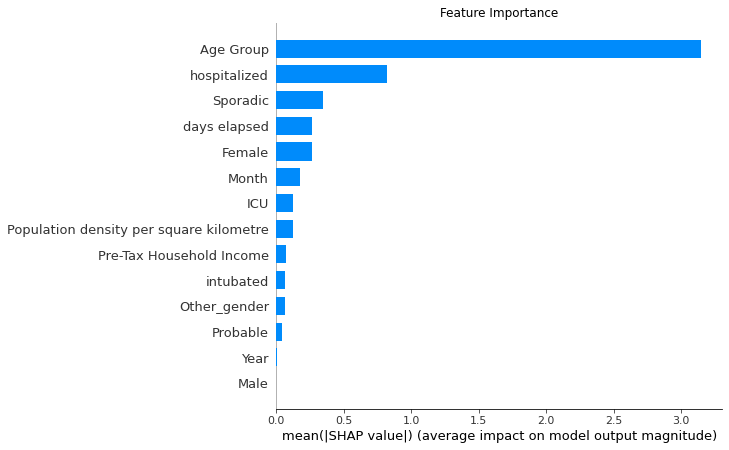

In [69]:
#Variable Importance Plot
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show = False)

plt.title('Feature Importance')

plt.show()

The figure above shows SHAP feature importance for our XGBoost model.

- `Age Group` : Age is the most important feature in our model, changing the predicted Covid mortality rate by more than 3 percent on average.

- `hospitalized` : Individuals who had been hospitalized for Covid are another important feature in predicting the Covid mortality rate. The other two hospitalization-related variables `ICU` (ever in ICU) and `intubated` (ever intubated) had a much lesser impact on model output. The history of hospitalization for Covid 19 is a good predictor of mortality rate, as they might be proxies for other health conditions and diseases associated with Covid.

- `sporadic` : sporadic cases or outbreak associated cases: Outbreak associated cases from health care institutions and health care settings have an impact on mortality rate.

- `days elasped` : time is also a good predictor and important feature in our model.

Feature importance plot provides an overview of which features are important for our model by calculating the mean absolute SHAP values, next we will look at the local feature importance summary that shows the direction of the relationship between a feature and the outcome as well.

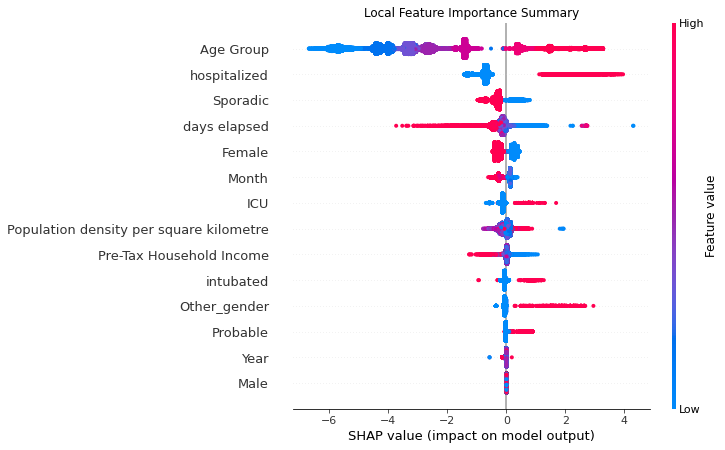

In [74]:
#create shap summary plot
shap.initjs() 

plt.figure(figsize=(15,10))

shap.summary_plot(shap_values, X_test_shap, show=False)

plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

plt.title('Local Feature Importance Summary')
plt.savefig('Shap.pdf', dpi = 400, bbox_inches='tight') #-export figure to PDF

plt.show()


Features are ranked in order based on feature importance. High feature value in red and low feature value in blue. 

- `age` : older age group has a positive SHAP value and is associated with increased mortality risk. 

- `hospitalized` : This is a binary variable that takes values of 1 and 0, so individuals who are hospitalized (value of 1) from Covid are associated with increased mortality risk. This is the same for `ICU` and `intubated`.

- `days elapsed` : The variable is created by calculating the difference between patient's episode date and the date of the first Covid case reported to Toronto Public Health. A higher number of elapsed days (more recent cases) have a negative impact on Covid mortality. We definitely see a declining trend in Covid deaths globally,  the virus seems to be less dangerous as it evolves and vaccines help prevent severe illness and death even if patients get covid. Whereas, the mortality rate is higher in the early stages of the outbreak (low number of elapsed days).

- `Pre-Tax Household Income`: higher pre-tax household income reduce covid mortality risk.

- `Other gender` : other gender includes trans people, unknown, and other non-binary people. This group/ category of people are more vulnerable and at a higher risk of covid mortality. However, they only make up a very small proportion of our data and ha a very low feature importance. More research needs to be conducted to examine the risk of Covid 19 in transgender community.


## Conclusion

Three machine learning models (LASSO regression, Random Forest, and XGBoost) are applied to predict Covid mortality. We tuned the hyperparameter with GridSearchCV for all three models, and after adjusting for imbalanced class, both LASSO regression and XGBoost had a very high AUC score of 0.938 and 0.940 respectively, with XGBoost performing slightly better in getting a higher accuracy score and F1 score. For model interpretation, we focused on the XGBoost model and used the SHAP package to compute feature importance to explore the positive and negative relationship of each individual feature with our target variable. Machine learning models are shown to be able to predict mortality risk among infected individuals accurately and identify severe Covid-19 patients early with few easily accessible variables. Variables such as age, gender, hospital records from Covid, and time are shown to be good predictors of Covid mortality risk.

## Next Step
- XGBoost model performed the best and I could definitely improve the results by spending more time on fine-tuning and optimizing the model.

- application of neural network to predict Covid mortality risk

- Incorporate other demographic factors such as race, ethnicity, and education in our model

- This dataset only looks at cases from the City of Toronto, I would like to investigate and apply our model to a larger and more diverse population

## References

1. Predicting COVID-19 mortality risk in Toronto, Canada: a comparison of tree-based and regression-based machine learning methods<br>
https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-021-01441-4

2. Comparing machine learning algorithms for predicting COVID-19 mortality<br>
https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01742-0

3. Development and validation of a machine learning model to predict mortality risk in patients with COVID-19<br> 
https://informatics.bmj.com/content/28/1/e100235

4. Machine-learning-based COVID-19 mortality prediction model and identification of patients at low and high risk of dying<br>
https://ccforum.biomedcentral.com/articles/10.1186/s13054-021-03749-5

5. Using Machine Learning to Predict Mortality for COVID-19 Patients on Day 0 in the ICU<br>
https://www.frontiersin.org/articles/10.3389/fdgth.2021.681608/full

6. Examining the elevated risk of COVID-19 in transgender communities with an intersectional lens <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8492083/

7. 5 Things Everyone Should Know About the Coronavirus Outbreak <br>
https://www.yalemedicine.org/news/2019-novel-coronavirus

8. Interpretable Machine Learning -A Guide for Making Black Box Models Explainable <br>
https://christophm.github.io/interpretable-ml-book/shapley.html

9. Explain Your Model with the SHAP Values <br>
https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d